In [1]:
import numpy as np
import uproot
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib
# matplotlib.rcParams['figure.dpi'] = 300

In [3]:
comp_list = {
    'ParticleNet': '../../outputs/20211013-190248_particlenet_pf_ranger_lr0.005_batch128/predict_output/pred.root',
    'PFN': '../../outputs/20211013-190425_pfn_pf_ranger_lr0.005_batch128/predict_output/pred.root',
}

In [4]:
def bkg_rej(tpr, fpr, eff=0.5):
    idx = next(idx for idx, v in enumerate(tpr) if v>eff)
#     print('tpr=%.3f, fpr=%.6f, 1/fpr=%.2f'%(tpr[idx], fpr[idx], 1/fpr[idx]))
    rej = 1/fpr[idx]
    return rej

In [5]:
def plot(comp_list, output=None, eff_wps=[0.5, 0.3]):
    
    f, ax = plt.subplots()

    bkg_name = 'jet_isQCD'
    sig_name = 'jet_isTop'

    for name, fp in comp_list.items():                
        df = uproot.open(fp)['Events'].arrays(library='pd')
        y_true = df[sig_name].values
        y_pred = df[f'score_{sig_name}'].values

        acc = accuracy_score(y_true, y_pred>0.5)

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)

        bkgrejs = {eff: bkg_rej(tpr, fpr, eff) for eff in eff_wps}

        print(name)
        print(' - accuracy: ', acc)
        print(' - AUC: ', auc)
        for eff, rej in bkgrejs.items():
            print(' - 1/eff_bkg @ eff_sig=%f: %.0f' % (eff, rej))

        ax.plot(tpr, fpr, label='%s (AUC = %.4f)'%(name, auc))

    ax.legend(loc='best', fontsize=16)
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 1)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Signal efficiency', horizontalalignment='right', x=1.0)
    ax.set_ylabel('Background efficiency', horizontalalignment='right', y=1.0)

    if output is not None:
        f.savefig(output + '.pdf')

ParticleNet
 - accuracy:  0.9396311881188119
 - AUC:  0.9854836891882504
 - 1/eff_bkg @ eff_sig=0.500000: 385
 - 1/eff_bkg @ eff_sig=0.300000: 1485


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


PFN
 - accuracy:  0.9218267326732673
 - AUC:  0.9751710341477544
 - 1/eff_bkg @ eff_sig=0.500000: 124
 - 1/eff_bkg @ eff_sig=0.300000: 399


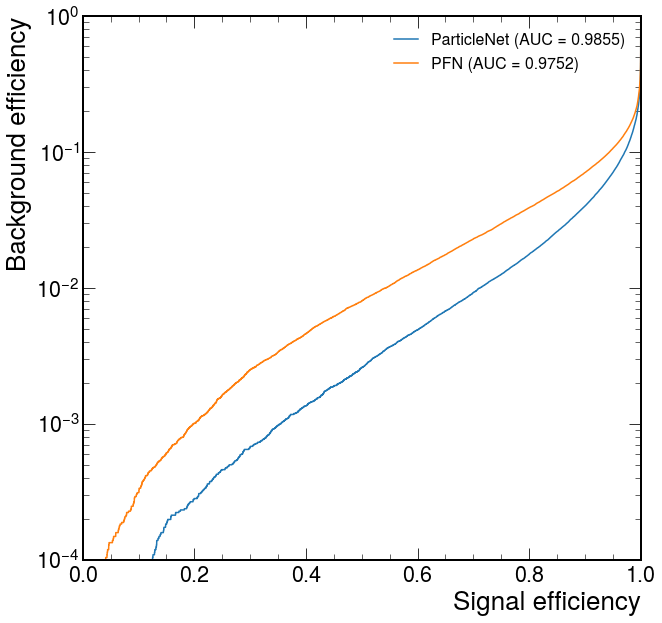

In [6]:
plot(comp_list)